In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline 
#For inline plotting, commands in cells below the cell that outputs a plot will not affect the plot.

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools #print(list(itertools. takewhile(lambda x: x % 2 == 0, list1))) instead of loops
from tensorflow.keras.optimizers import RMSprop # uses 2nd moment with a decay rate to speed up
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from keras.preprocessing.image import ImageDataGenerator #rotate images through any degree between 0 and 360
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
#Reduce learning rate when a metric has stopped improving
#Stop training when a monitored metric has stopped improving

sns.set(style='white', context='notebook', palette='deep') #color mapping 

In [ ]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

In [ ]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

In [ ]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

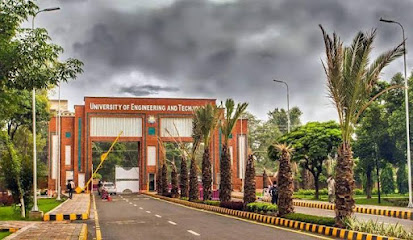

In [ ]:
Image.open('/content/2022-04-24.jpg')

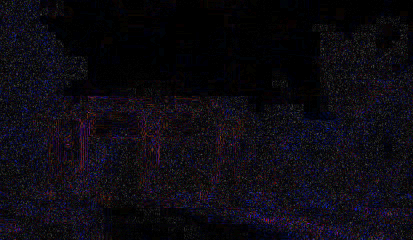

In [ ]:
convert_to_ela_image('/content/2022-04-24.jpg', 90)

In [ ]:
dataset ="/content/drive/MyDrive/Colab Notebooks/real_and_fake_face"

In [ ]:
import os
os.listdir(dataset)

['training_real', 'training_fake']

In [ ]:
os.listdir(os.path.join(dataset,'training_real'))

In [ ]:
image_exts = ['jpeg','jpg', 'png']

In [ ]:
for image_class in os.listdir(dataset): 
  print(image_class)

training_real
training_fake


In [ ]:
import cv2
img=cv2.imread(os.path.join('/content/drive/MyDrive/Colab Notebooks/real_and_fake_face/training_real/real_00001.jpg'))
img

array([[[ 93, 186, 201],
        [ 89, 182, 197],
        [ 82, 177, 192],
        ...,
        [139, 156, 213],
        [136, 153, 210],
        [139, 158, 215]],

       [[ 79, 172, 187],
        [ 78, 173, 188],
        [ 79, 174, 189],
        ...,
        [138, 154, 213],
        [134, 150, 209],
        [137, 153, 212]],

       [[ 62, 157, 172],
        [ 67, 162, 177],
        [ 74, 171, 185],
        ...,
        [132, 146, 205],
        [127, 143, 202],
        [131, 147, 206]],

       ...,

       [[107,  75,  99],
        [111,  79, 103],
        [117,  86, 107],
        ...,
        [ 32,  21,  23],
        [ 31,  22,  25],
        [ 32,  23,  26]],

       [[105,  76,  99],
        [109,  80, 103],
        [114,  85, 108],
        ...,
        [ 31,  20,  22],
        [ 31,  22,  25],
        [ 33,  24,  27]],

       [[109,  80, 103],
        [114,  85, 108],
        [119,  90, 113],
        ...,
        [ 30,  19,  21],
        [ 33,  22,  25],
        [ 33,  24,  27]]

In [ ]:
import tensorflow as tf
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/real_and_fake_face')

Found 4082 files belonging to 2 classes.


In [ ]:
#converts input image to ela applied image
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    #resaving input image at the desired quality
    resaved_file_name = 'resaved_image.jpg'     #predefined filename for resaved image
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    #pixel difference between original and resaved image
    ela_image = ImageChops.difference(original_image,resaved_image)
    
    #scaling factors are calculated from pixel extremas
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 350.0 / max_difference
    
    #enhancing elaimage to brighten the pixels
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    ela_image.save("ela_image.png")
    return ela_image

In [ ]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0  

In [ ]:
from tqdm.notebook import tqdm  #te quiero demasiado(arabic ily) #smart progress meter #wraps aany iterable
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real
#adding authentic images

path = '/content/drive/MyDrive/Colab Notebooks/real_and_fake_face/training_real'       #folder path of the authentic images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(1)     # label for authentic images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')
#adding forged images

path = '/content/drive/MyDrive/Colab Notebooks/real_and_fake_face/training_fake'       #folder path of the forged images in the dataset
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(0)     # label for forged images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1, 128, 128, 3) 

Processing Images :   0%|          | 0/2162 [00:00<?, ?it/s]

Total images: 2162
Total labels: 2162


Processing Images :   0%|          | 0/1920 [00:00<?, ?it/s]

In [ ]:
# Training : Validation : Testing = 76 : 19 : 5
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

Training images: 3265 , Training labels: 3265
Validation images: 817 , Validation labels: 817
Test images: 205 , Test labels: 205


In [ ]:
from keras.layers import GlobalAveragePooling2D
def build_model():
    model = Sequential()  # Sequential Model
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'sigmoid'))
    return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 64)      4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        102464    
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0         
 2D)                                                    

In [ ]:
epochs = 40
batch_size = 32
#Optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1) 
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_val, Y_val))

Epoch 1/40
103/103 [==============================] - 1205s 12s/step - loss: 0.6915 - accuracy: 0.5305 - val_loss: 0.6954 - val_accuracy: 0.5165
Epoch 2/40
103/103 [==============================] - 1173s 11s/step - loss: 0.6913 - accuracy: 0.5329 - val_loss: 0.6926 - val_accuracy: 0.5165
Epoch 3/40
103/103 [==============================] - 1221s 12s/step - loss: 0.6914 - accuracy: 0.5329 - val_loss: 0.6926 - val_accuracy: 0.5165
Epoch 4/40
